### Cora dataset(数据集描述：[Yang et al. (2016)](https://arxiv.org/abs/1603.08861))
- 论文引用数据集，每一个点有1433维向量
- 最终要对每个点进行7分类任务(每个类别只有20个点有标注)

In [2]:
from torch_geometric.datasets import Planetoid#下载数据集用的
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())#transform预处理

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


- val_mask和test_mask分别表示这个点需要被用到哪个集中

In [3]:
# 可视化部分
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

### 试试直接用传统的全连接层会咋样(Multi-layer Perception Network)

In [4]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [5]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9609
Epoch: 002, Loss: 1.9558
Epoch: 003, Loss: 1.9485
Epoch: 004, Loss: 1.9413
Epoch: 005, Loss: 1.9297
Epoch: 006, Loss: 1.9266
Epoch: 007, Loss: 1.9124
Epoch: 008, Loss: 1.9024
Epoch: 009, Loss: 1.8985
Epoch: 010, Loss: 1.8849
Epoch: 011, Loss: 1.8753
Epoch: 012, Loss: 1.8684
Epoch: 013, Loss: 1.8483
Epoch: 014, Loss: 1.8465
Epoch: 015, Loss: 1.8115
Epoch: 016, Loss: 1.8143
Epoch: 017, Loss: 1.7900
Epoch: 018, Loss: 1.7985
Epoch: 019, Loss: 1.7639
Epoch: 020, Loss: 1.7383
Epoch: 021, Loss: 1.7229
Epoch: 022, Loss: 1.7452
Epoch: 023, Loss: 1.7000
Epoch: 024, Loss: 1.6855
Epoch: 025, Loss: 1.6691
Epoch: 026, Loss: 1.6479
Epoch: 027, Loss: 1.6284
Epoch: 028, Loss: 1.5960
Epoch: 029, Loss: 1.5562
Epoch: 030, Loss: 1.5396
Epoch: 031, Loss: 1.5488
Epoch: 032, Loss: 1.5224
Epoch: 033, Loss: 1.4665
Epoch: 034, Loss: 1.4885
Epoch: 035, Loss: 1.4399
Epoch: 036, Loss: 1.4035
Epoch: 037, Loss: 1.4265
Epoch: 038, Loss: 1.3742
Epoch: 039, Loss: 1.3742
Epoch: 040, Loss: 1.3391


准确率计算

In [6]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5740


## Graph Neural Network (GNN)

将全连接层替换成GCN层

In [7]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


可视化时由于输出是7维向量，所以降维成2维进行展示

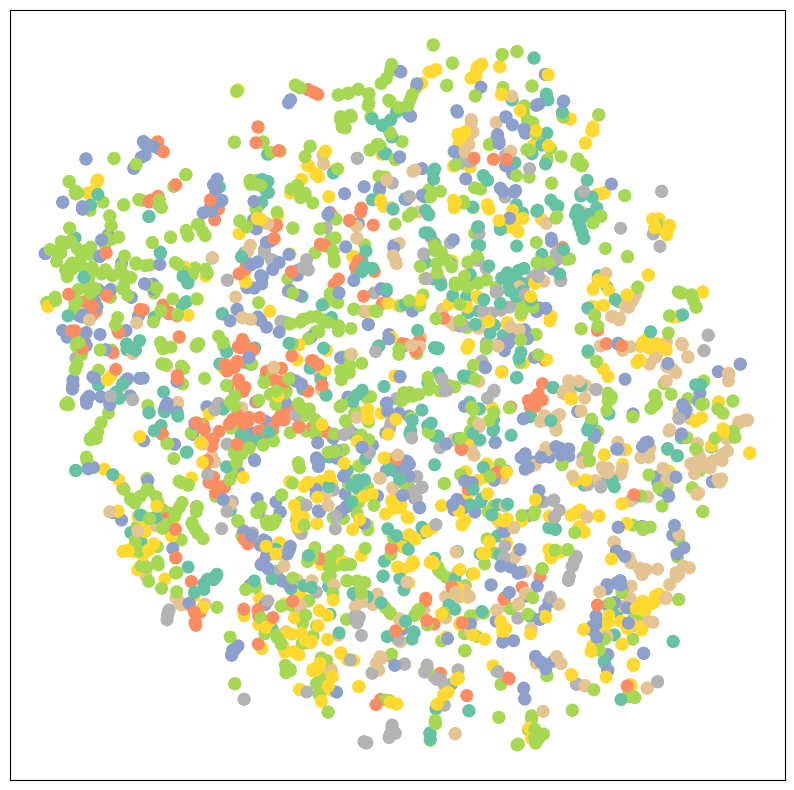

In [8]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

训练GCN模型

In [9]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  
    out = model(data.x, data.edge_index)  
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  
    loss.backward() 
    optimizer.step()  
    return loss

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
    return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9465
Epoch: 002, Loss: 1.9419
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9290
Epoch: 005, Loss: 1.9199
Epoch: 006, Loss: 1.9140
Epoch: 007, Loss: 1.9079
Epoch: 008, Loss: 1.8992
Epoch: 009, Loss: 1.8876
Epoch: 010, Loss: 1.8764
Epoch: 011, Loss: 1.8656
Epoch: 012, Loss: 1.8626
Epoch: 013, Loss: 1.8460
Epoch: 014, Loss: 1.8329
Epoch: 015, Loss: 1.8225
Epoch: 016, Loss: 1.8167
Epoch: 017, Loss: 1.7995
Epoch: 018, Loss: 1.7878
Epoch: 019, Loss: 1.7716
Epoch: 020, Loss: 1.7568
Epoch: 021, Loss: 1.7563
Epoch: 022, Loss: 1.7342
Epoch: 023, Loss: 1.7092
Epoch: 024, Loss: 1.7015
Epoch: 025, Loss: 1.6671
Epoch: 026, Loss: 1.6757
Epoch: 027, Loss: 1.6609
Epoch: 028, Loss: 1.6355
Epoch: 029, Loss: 1.6339
Epoch: 030, Loss: 1.6102
Epoch: 031, Loss: 1.5964
Epoch: 032, Loss: 1.5721
Epoch: 033, Loss: 1.5570
Epoch: 034, Loss: 1.5445
Epoch: 035, Loss: 1.5093
Epoch: 036, Loss: 1.4889
Epoch: 037, Loss: 1.4776
Epoch: 038, Loss: 1.4704
Epoch: 039, Loss: 1.4263
Epoch: 040, Loss: 1.3972


准确率计算

In [10]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8110


从59%到81%，这个提升还是蛮大的；训练后的可视化展示如下：

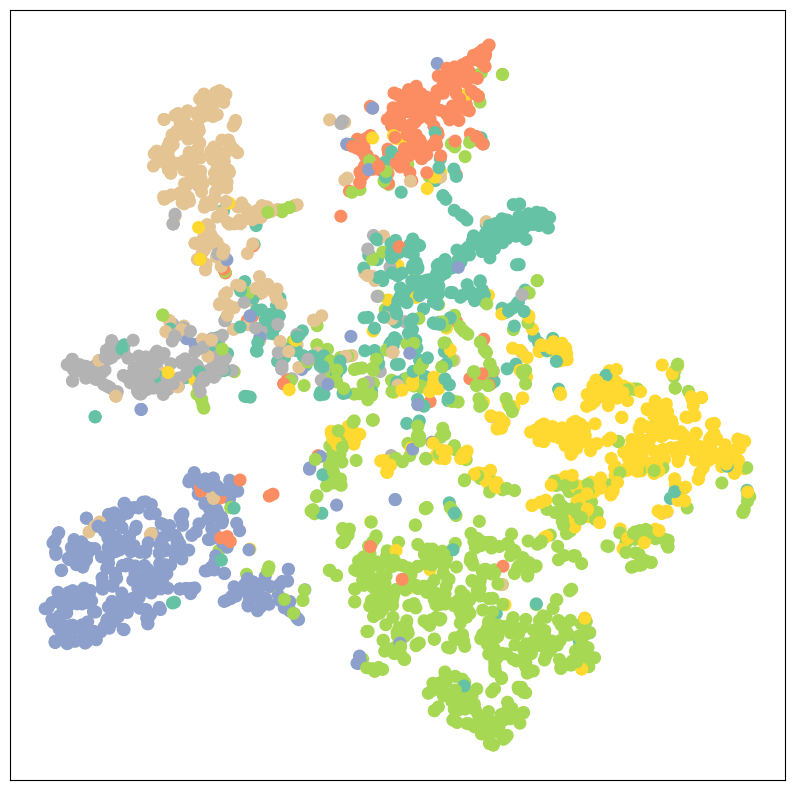

In [11]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)